In [1]:
# lib dependency
import soundfile as sf
from scipy import signal
import random
import numpy as np
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
import torch.utils.data
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.utils import class_weight
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
import h5py
import csv
import pandas as pd
from glob import glob
import librosa
import librosa.display

import utils

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cpu


In [2]:
import os
import re
from glob import glob

path = "../HRTF/IRC_*"
names = []
names += glob(path)
print(names[0])

splitnames = [os.path.split(name) for name in names]
print(len(splitnames))

p = re.compile('IRC_\d{4,4}')
print(p)

subjects = [int(name[4:8]) for base, name in splitnames 
                         if not (p.match(name[-8:]) is None)]
print(subjects)

from scipy.io import loadmat

k = 0
subject = subjects[k]

for k in range(len(names)):
    subject = subjects[k]
    # filename = os.path.join(names[k], 'IRC_' + str(subject))
    filename = os.path.join(names[k], 'COMPENSATED/MAT/HRIR/IRC_' + str(subject) + '_C_HRIR.mat')
#     print(filename)

import numpy as np
import matplotlib.pyplot as plt 

m = loadmat(filename, struct_as_record=True)
print(m.keys())
print(m['l_eq_hrir_S'].dtype)

l, r = m['l_eq_hrir_S'], m['r_eq_hrir_S']
hrirSet_l = l['content_m'][0][0]
hrirSet_r = r['content_m'][0][0]
elev = l['elev_v'][0][0]
azim = l['azim_v'][0][0]
fs_HRIR = m['l_eq_hrir_S']['sampling_hz'][0][0][0][0]

locLabel = np.hstack((elev, azim))
print("locLabel shape: ", locLabel.shape, " (order: elev, azim)")
# print(locLabel[0:5])

# 0: left-ear 1: right-ear
hrirSet = np.vstack((np.reshape(hrirSet_l, (1,) + hrirSet_l.shape),
                          np.reshape(hrirSet_r, (1,) + hrirSet_r.shape)))
hrirSet = np.transpose(hrirSet, (1,0,2))
print("hrirSet shape: ", hrirSet.shape)

if False:
    for i in range(51,53):
        plt.plot(hrirSet[i, 0])
        plt.plot(hrirSet[i, 1])
        plt.legend(['left','right'], loc='best')
        plt.title('elevation: '+str(locLabel[i, 0])+' azimuth: '+str(locLabel[i, 1]))
        plt.show()


../HRTF\IRC_1002
1
re.compile('IRC_\\d{4,4}')
[1002]
dict_keys(['__header__', '__version__', '__globals__', 'r_eq_hrir_S', 'l_eq_hrir_S'])
[('elev_v', 'O'), ('azim_v', 'O'), ('type_s', 'O'), ('sampling_hz', 'O'), ('content_m', 'O')]
locLabel shape:  (187, 2)  (order: elev, azim)
hrirSet shape:  (187, 2, 512)


In [3]:
basedir = os.getcwd()
print(basedir)
# path = glob(os.path.join(basedir, "/drive/MyDrive/SSSL/audio/*"))
path = glob(os.path.join("../audio/*"))
Naudio = len(path)
print(path)
print("Number of audio files: ",Naudio)

# left-ear and right-ear signal pairs
sigPairList = []
# audioIndex = -1
Nloc = 24 # hrirSet.shape[0]
lenHRIR = hrirSet.shape[-1]
valSNRList = [100]
lenSliceInSec = 1
fileCount = -1
dirName = '/pt/'

for audioIndex in range(1): # len(path)
    audioPath = path[audioIndex]
    audioData, fs_audio = sf.read(audioPath)
    print(audioData.shape)
    print("Audio sample rate: ", fs_audio)

    audioSliceList = utils.audioSliceGenerator(audioData, fs_audio, lenSliceInSec)

    sliceIndex = -1
    Nsamples = len(audioSliceList)
    print("Number of samples: ",Nsamples)
    lenTruncate = len(audioSliceList[0])
    audio = audioData[audioSliceList[0]]
    # re-sample [todo]
    audio = librosa.resample(audio, fs_audio, fs_HRIR)
    lenAfterConv = lenHRIR + audio.size - 1
    
    sigPair = np.zeros((Nsamples, Nloc, 2, lenAfterConv))
    labels = np.zeros((Nsamples, Nloc))
    print("Initialise sigPair", sigPair.shape)

    for audioSlice in audioSliceList:
        sliceIndex += 1  

        audio = audioData[audioSlice]
        # re-sample [todo]
        audio = librosa.resample(audio, fs_audio, fs_HRIR)
        lenAfterConv = lenHRIR + audio.size - 1
        # print(len(audioSlice))
        # shape after convolution: 512 + audio length - 1

        # hrirSet is of shape (187, 2, 512)
        for locIndex in range(Nloc): 
            # # re-sample [todo]
            # temp = librosa.resample(hrirSet[24*3+locIndex, 0], fs_HRIR, fs_audio)
            sigLeft = np.convolve(audio, hrirSet[24*3+locIndex, 0])
            sigRight = np.convolve(audio, hrirSet[24*3+locIndex, 1])

            sigPair[sliceIndex, locIndex, 0] = sigLeft.reshape(1, sigLeft.shape[0])
            sigPair[sliceIndex, locIndex, 1] = sigRight.reshape(1, sigRight.shape[0])

            labels[sliceIndex, locIndex] = locIndex

            for valSNR in valSNRList:
                fileCount += 1
                cues = utils.binauralCues(sigPair[sliceIndex, locIndex], fs_HRIR, valSNR)
                cues = torch.from_numpy(cues.astype(np.float32))

                ''' # save cues
                if fileCount == 0:
                    print(cues.shape)
                    if not os.path.isdir('D:/SSSL/'+dirName):
                        os.mkdir('D:/SSSL'+dirName)

                    with open('D:/SSSL/'+dirName+'dataLabels.csv', 'w') as csvFile:
                        csvFile.write(str(fileCount))
                        csvFile.write(',')
                        csvFile.write(str(locIndex))
                        csvFile.write('\n')
                else:
                    with open('D:/SSSL/'+dirName+'dataLabels.csv', 'a') as csvFile:
                        csvFile.write(str(fileCount))
                        csvFile.write(',')
                        csvFile.write(str(locIndex))
                        csvFile.write('\n')

                torch.save(cues, 'D:/SSSL/'+dirName+str(fileCount)+'.pt')
                '''
    
    

    # del sigLeft, sigRight


    # raise SystemExit("Stop right there!")

    # del sigPair

    # sigPairList.append(sigPair)
    

c:\Users\mynam\Documents\GitHub\Simultaneous-Sound-Localisation-Transformer\src
['../audio\\music-fma-0001.wav', '../audio\\music-fma-0002.wav', '../audio\\music-fma-0003.wav', '../audio\\music-fma-0004.wav', '../audio\\music-fma-0005.wav', '../audio\\music-fma-0006.wav']
Number of audio files:  6
(3488705,)
Audio sample rate:  16000
Number of samples:  210
Initialise sigPair (210, 24, 2, 44611)


In [4]:
f, t, Zxx_l_no = signal.stft(
    sigPair[0,0,0] 
    # + utils.noiseGenerator(sigPair[0,0,0], 100) # noise added
    , fs_HRIR, nperseg = 1023
)
              
f, t, Zxx_l_100 = signal.stft(
    sigPair[0,0,0] 
    + utils.noiseGenerator(sigPair[0,0,0], 100) # noise added
    , fs_HRIR, nperseg = 1023
)       

f, t, Zxx_l_10 = signal.stft(
    sigPair[0,0,0] 
    + utils.noiseGenerator(sigPair[0,0,0], 10) # noise added
    , fs_HRIR, nperseg = 1023
)

In [6]:
plt.pcolormesh(t, f, np.abs(Zxx_l_no), shading='gouraud')
plt.title('STFT Magnitude (L) for location #')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

plt.pcolormesh(t, f, np.abs(Zxx_l_100), shading='gouraud')
plt.title('STFT Magnitude (L) for location #')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

plt.pcolormesh(t, f, np.abs(Zxx_l_10), shading='gouraud')
plt.title('STFT Magnitude (L) for location #')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()


In [29]:
Zxx_l_no = librosa.stft(
    sigPair[0,0,0]
    # + utils.noiseGenerator(sigPair[0,0,0], 100)
    , 1023
)
Zxx_l_100 = librosa.stft(
    sigPair[0,0,0]
    + utils.noiseGenerator(sigPair[0,0,0], 100)
    , 1023
)
Zxx_l_10 = librosa.stft(
    sigPair[0,0,0]
    + utils.noiseGenerator(sigPair[0,0,0], 10)
    , 1023
)
print(Zxx_l_no.shape, Zxx_l_100.shape, Zxx_l_10.shape)

(512, 175) (512, 175) (512, 175)


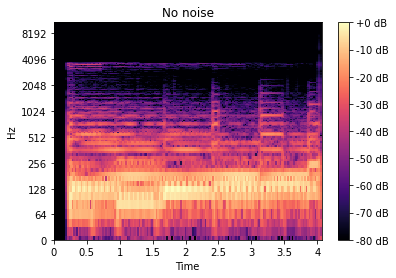

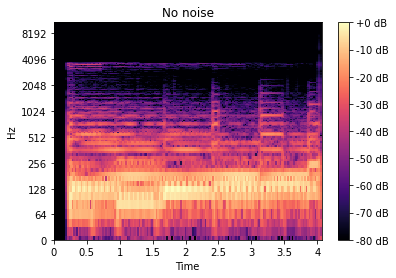

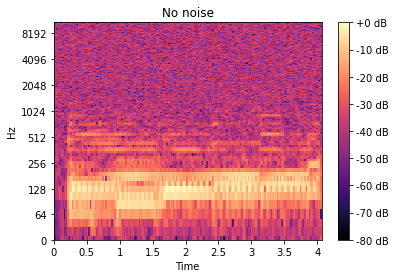

In [33]:
fig, ax = plt.subplots()

img = librosa.display.specshow(librosa.amplitude_to_db(Zxx_l_no,

                                                       ref=np.max),

                               y_axis='log', x_axis='time', ax=ax)

ax.set_title('No noise')

fig.colorbar(img, ax=ax, format="%+2.0f dB")

# 
fig, ax = plt.subplots()

img = librosa.display.specshow(librosa.amplitude_to_db(Zxx_l_100,

                                                       ref=np.max),

                               y_axis='log', x_axis='time', ax=ax)

ax.set_title('No noise')

fig.colorbar(img, ax=ax, format="%+2.0f dB")

#
fig, ax = plt.subplots()

img = librosa.display.specshow(librosa.amplitude_to_db(Zxx_l_10,

                                                       ref=np.max),

                               y_axis='log', x_axis='time', ax=ax)

ax.set_title('No noise')

fig.colorbar(img, ax=ax, format="%+2.0f dB")

./HRTF\IRC_1002
1
re.compile('IRC_\\d{4,4}')
[1002]
dict_keys(['__header__', '__version__', '__globals__', 'r_eq_hrir_S', 'l_eq_hrir_S'])
[('elev_v', 'O'), ('azim_v', 'O'), ('type_s', 'O'), ('sampling_hz', 'O'), ('content_m', 'O')]
locLabel shape:  (187, 2)  (order: elev, azim)
hrirSet shape:  (187, 2, 512)
(187, 2, 512)
(187, 2, 186)
Preprocessing method: normalise
Preprocessing method: standardise
Spectrogram shape:  (512, 44)


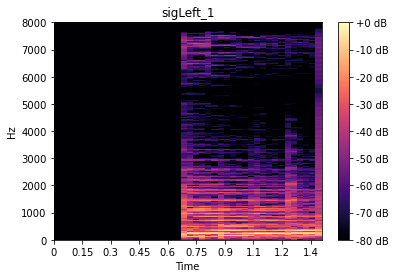

Spectrogram shape:  (512, 44)


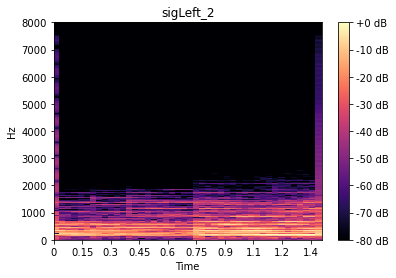

In [1]:
import torch
import torch.nn as nn
import soundfile as sf
from scipy import signal
from glob import glob

from utils import *
from vis import *
from data_loader import *

path = "./HRTF/IRC*"
hrirSet, locLabel, fs_HRIR = loadHRIR(path)
print(hrirSet.shape)

# temp = torch.load("./saved_cues_2Sound_norm_temp/train/0.pt")
# temp = temp.numpy()
# print(temp[:,:,1].shape)
class CuesShape:
    def __init__(
        self,
        Nfreq = 512,
        Ntime = 44,
        Ncues = 5,
        Nloc = 187,
        lenSliceInSec = 0.5,
        valSNRList = [-5,0,5,10,15,20,25,30,35]
    ):
        self.Nfreq = Nfreq
        self.Ntime = Ntime
        self.Ncues = Ncues
        self.Nloc = Nloc
        self.lenSliceInSec = lenSliceInSec
        self.valSNRList = valSNRList

trainAudioPath = glob(os.path.join("./audio_train/*"))

_, fs_audio = sf.read(trainAudioPath[0])
temp = librosa.resample(hrirSet[0, 0], fs_HRIR, fs_audio)
hrirSet_re = np.empty(hrirSet.shape[0:2]+temp.shape)
for i in range(hrirSet.shape[0]):
    hrirSet_re[i, 0] = librosa.resample(hrirSet[i, 0], fs_HRIR, fs_audio)
    hrirSet_re[i, 1] = librosa.resample(hrirSet[i, 1], fs_HRIR, fs_audio)
print(hrirSet_re.shape)
del temp, hrirSet

cuesShape = CuesShape()
lenSliceInSec = 0.5
normalise = Preprocess(prep_method="normalise")
standardise = Preprocess(prep_method="standardise")

audio_1, fs_audio_1 = sf.read(trainAudioPath[0])
audio_2, fs_audio_2 = sf.read(trainAudioPath[1])
audioSliceList_1 = audioSliceGenerator(audio_1, fs_HRIR, lenSliceInSec)
audioSliceList_2 = audioSliceGenerator(audio_2, fs_HRIR, lenSliceInSec)

sliceIndex_1 = 0
sliceIndex_2 = 1

audioSlice_1 = audio_1[audioSliceList_1[sliceIndex_1]]
audioSlice_2 = audio_2[audioSliceList_2[sliceIndex_2]]
locIndex_1 = 0
locIndex_2 = 12

sigLeft_1 = np.convolve(audioSlice_1, hrirSet_re[locIndex_1, 0])
sigRight_1 = np.convolve(audioSlice_1, hrirSet_re[locIndex_1, 1])
sigLeft_2 = np.convolve(audioSlice_2, hrirSet_re[locIndex_2, 0])
sigRight_2 = np.convolve(audioSlice_2, hrirSet_re[locIndex_2, 1])

specLeft_1 = calSpectrogram(sigLeft_1, fs_audio)
specRight_1 = calSpectrogram(sigRight_1, fs_audio)
specLeft_2 = calSpectrogram(sigLeft_2, fs_audio)
specRight_2 = calSpectrogram(sigRight_2, fs_audio)

specLeft = normalise(calSpectrogram(sigLeft_1 + sigLeft_2, fs_audio))
specRight = normalise(calSpectrogram(sigRight_1 + sigRight_2, fs_audio))

ipdCues_1 = normalise(calIPD(specLeft_1, specRight_1))
ipdCues_2 = normalise(calIPD(specLeft_2, specRight_2))
ipdCues = normalise(calIPD(specLeft, specRight))
ipdCues_unwrap_1 = normalise(calIPD_unwrap(specLeft_1, specRight_1))
ipdCues_unwrap_2 = normalise(calIPD_unwrap(specLeft_2, specRight_2))
ipdCues_unwrap = normalise(calIPD_unwrap(specLeft, specRight))
r_l, theta_l = cartesian2euler(specLeft)
r_r, theta_r = cartesian2euler(specRight)
r_l = normalise(r_l)
theta_l = normalise(theta_l)
r_r = normalise(r_r)
theta_r = normalise(theta_r)

r_l_1, theta_l_1  = cartesian2euler(specLeft_1)
r_r_1, theta_r_1  = cartesian2euler(specRight_1)
r_l_1 = normalise(r_l_1)
theta_l_1 = normalise(theta_l_1)
r_r_1 = normalise(r_r_1)
theta_r_1 = normalise(theta_r_1)

r_l_2, theta_l_2  = cartesian2euler(specLeft_2)
r_r_2, theta_r_2  = cartesian2euler(specRight_2)
r_l_2 = normalise(r_l_2)
theta_l_2 = normalise(theta_l_2)
r_r_2 = normalise(r_r_2)
theta_r_2 = normalise(theta_r_2)


showSpectrogram(specLeft_1, fs=fs_audio, figTitle="sigLeft_1", isLog=True)
showSpectrogram(specLeft_2, fs=fs_audio, figTitle="sigLeft_2", isLog=True)

Spectrogram shape:  (512, 44)


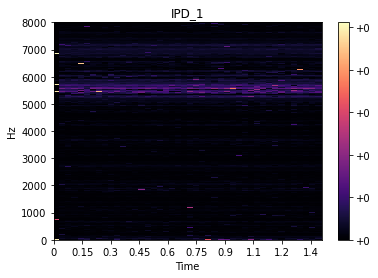

Spectrogram shape:  (512, 44)


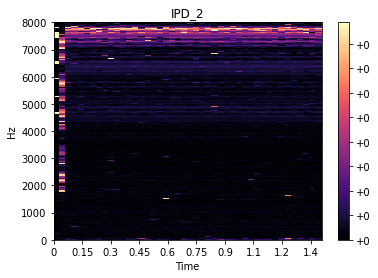

Spectrogram shape:  (512, 44)


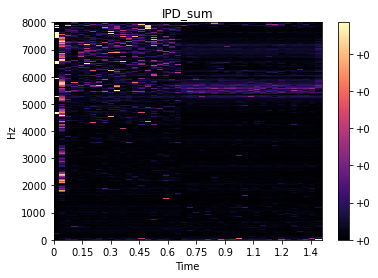

Spectrogram shape:  (512, 44)


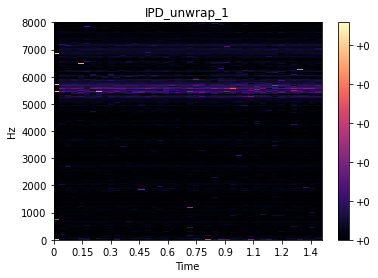

Spectrogram shape:  (512, 44)


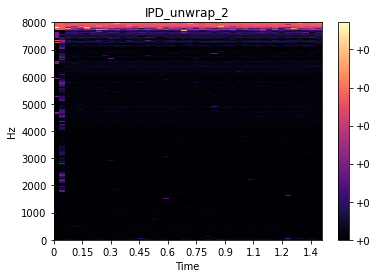

Spectrogram shape:  (512, 44)


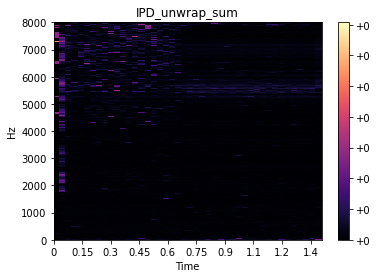

In [27]:
showSpectrogram(ipdCues_1, fs=fs_audio, figTitle="IPD_1", isLog=False)
showSpectrogram(ipdCues_2, fs=fs_audio, figTitle="IPD_2", isLog=False)
showSpectrogram(ipdCues, fs=fs_audio, figTitle="IPD_sum", isLog=False)
showSpectrogram(ipdCues_unwrap_1, fs=fs_audio, figTitle="IPD_unwrap_1", isLog=False)
showSpectrogram(ipdCues_unwrap_2, fs=fs_audio, figTitle="IPD_unwrap_2", isLog=False)
showSpectrogram(ipdCues_unwrap, fs=fs_audio, figTitle="IPD_unwrap_sum", isLog=False)

Spectrogram shape:  (512, 44)


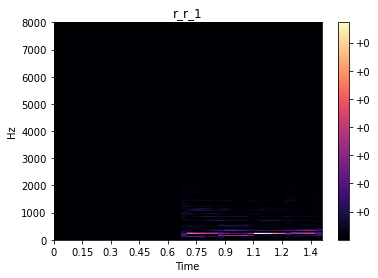

Spectrogram shape:  (512, 44)


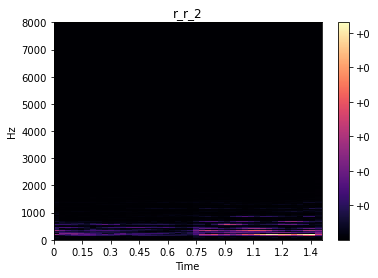

Spectrogram shape:  (512, 44)


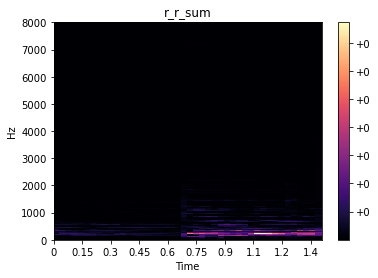

In [28]:
showSpectrogram(r_r_1, fs=fs_audio, figTitle="r_r_1", isLog=False)
showSpectrogram(r_r_2, fs=fs_audio, figTitle="r_r_2", isLog=False)
showSpectrogram(r_r, fs=fs_audio, figTitle="r_r_sum", isLog=False)

Spectrogram shape:  (512, 44)


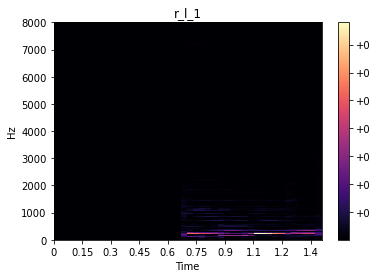

Spectrogram shape:  (512, 44)


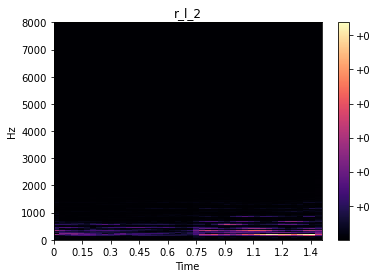

Spectrogram shape:  (512, 44)


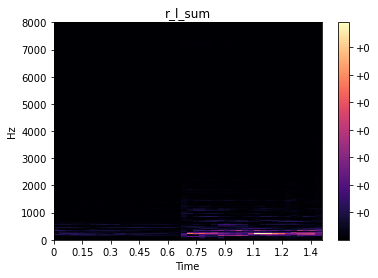

In [29]:
showSpectrogram(r_l_1, fs=fs_audio, figTitle="r_l_1", isLog=False)
showSpectrogram(r_l_2, fs=fs_audio, figTitle="r_l_2", isLog=False)
showSpectrogram(r_l, fs=fs_audio, figTitle="r_l_sum", isLog=False)

Spectrogram shape:  (512, 44)


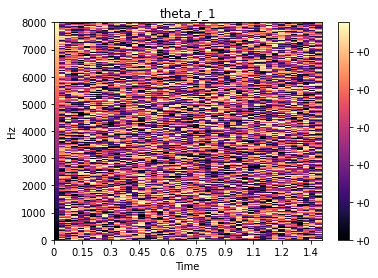

Spectrogram shape:  (512, 44)


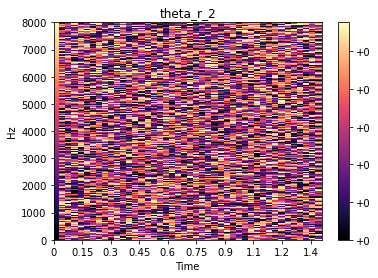

Spectrogram shape:  (512, 44)


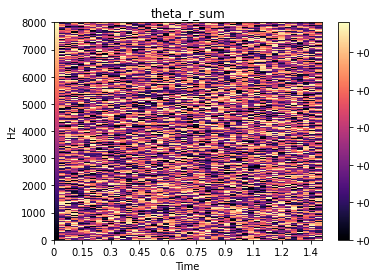

In [30]:
showSpectrogram(theta_r_1, fs=fs_audio, figTitle="theta_r_1", isLog=False)
showSpectrogram(theta_r_2, fs=fs_audio, figTitle="theta_r_2", isLog=False)
showSpectrogram(theta_r, fs=fs_audio, figTitle="theta_r_sum", isLog=False)

Spectrogram shape:  (512, 44)


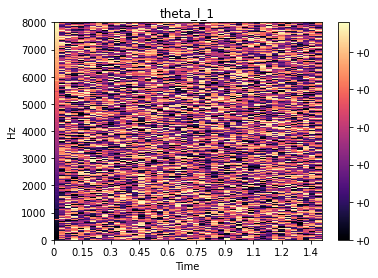

Spectrogram shape:  (512, 44)


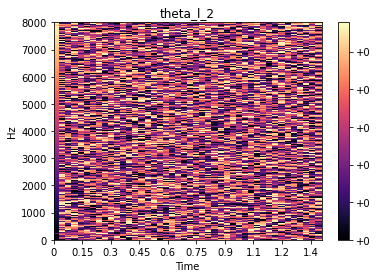

Spectrogram shape:  (512, 44)


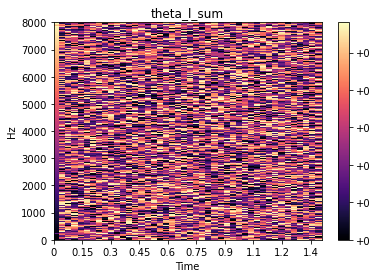

In [31]:
showSpectrogram(theta_l_1, fs=fs_audio, figTitle="theta_l_1", isLog=False)
showSpectrogram(theta_l_2, fs=fs_audio, figTitle="theta_l_2", isLog=False)
showSpectrogram(theta_l, fs=fs_audio, figTitle="theta_l_sum", isLog=False)

In [36]:
print(np.max(theta_l_1))
theta_l_1[:,0]

0.011564562508229044


array([ 0.00000000e+00,  1.68371288e-05,  6.49119192e-04,  5.85380550e-05,
        1.00841610e-04,  1.16739983e-04,  1.32044232e-04,  1.20457154e-04,
        9.86832987e-05,  2.22697946e-04,  2.10523675e-04,  2.90710225e-04,
        2.74698529e-04,  2.91459692e-04,  2.78079995e-04,  3.55910097e-04,
        3.57721334e-04,  3.83889468e-04,  3.84591592e-04,  4.52536209e-04,
        4.51896583e-04,  4.76412370e-04,  4.99591164e-04,  5.06342283e-04,
        5.93934438e-04,  6.16876216e-04,  5.89068761e-04,  6.04841305e-04,
        6.38539288e-04,  6.38404387e-04,  7.18800913e-04,  7.09899534e-04,
        7.19357788e-04,  7.20734940e-04,  7.95539706e-04,  7.93019076e-04,
        8.20882756e-04,  8.12906880e-04,  8.80822119e-04,  8.72265583e-04,
        9.04306450e-04,  9.39332220e-04,  9.39021672e-04,  9.01271840e-04,
        1.07072368e-03,  9.30702695e-04,  1.04604933e-03,  1.06712151e-03,
        1.08562319e-03,  7.93517964e-03,  1.13076503e-03,  1.11727678e-03,
        1.19041820e-03,  

In [15]:
temp = np.arange(0,10)
print(temp)
temp = np.tile(temp, (512,1))
temp = np.transpose(temp, axes=None)
temp = np.flip(temp)
# temp = temp.transpose(1,0)
print(temp.shape)
print(temp)

[0 1 2 3 4 5 6 7 8 9]
(10, 512)
[[9 9 9 ... 9 9 9]
 [8 8 8 ... 8 8 8]
 [7 7 7 ... 7 7 7]
 ...
 [2 2 2 ... 2 2 2]
 [1 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]


In [1]:
from utils import *

preprocess = Preprocess(prep_method="minmax")
temp = np.arange(0, 100).reshape(25,4)
print(temp)
print(preprocess(temp))

Preprocessing method: minmax
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]
 [16 17 18 19]
 [20 21 22 23]
 [24 25 26 27]
 [28 29 30 31]
 [32 33 34 35]
 [36 37 38 39]
 [40 41 42 43]
 [44 45 46 47]
 [48 49 50 51]
 [52 53 54 55]
 [56 57 58 59]
 [60 61 62 63]
 [64 65 66 67]
 [68 69 70 71]
 [72 73 74 75]
 [76 77 78 79]
 [80 81 82 83]
 [84 85 86 87]
 [88 89 90 91]
 [92 93 94 95]
 [96 97 98 99]]
[[0.         0.01010101 0.02020202 0.03030303]
 [0.04040404 0.05050505 0.06060606 0.07070707]
 [0.08080808 0.09090909 0.1010101  0.11111111]
 [0.12121212 0.13131313 0.14141414 0.15151515]
 [0.16161616 0.17171717 0.18181818 0.19191919]
 [0.2020202  0.21212121 0.22222222 0.23232323]
 [0.24242424 0.25252525 0.26262626 0.27272727]
 [0.28282828 0.29292929 0.3030303  0.31313131]
 [0.32323232 0.33333333 0.34343434 0.35353535]
 [0.36363636 0.37373737 0.38383838 0.39393939]
 [0.4040404  0.41414141 0.42424242 0.43434343]
 [0.44444444 0.45454545 0.46464646 0.47474747]
 [0.48484848 0.49494949 0.50505

# 0408 cues

./HRTF\IRC_1002
1
re.compile('IRC_\\d{4,4}')
[1002]
dict_keys(['__header__', '__version__', '__globals__', 'r_eq_hrir_S', 'l_eq_hrir_S'])
[('elev_v', 'O'), ('azim_v', 'O'), ('type_s', 'O'), ('sampling_hz', 'O'), ('content_m', 'O')]
locLabel shape:  (187, 2)  (order: elev, azim)
hrirSet shape:  (187, 2, 512)
(187, 2, 186)
how many slices:  3 9
78880
Preprocessing method: minmax
ild  (512, 44)
512 44
Spectrogram shape:  (512, 44)


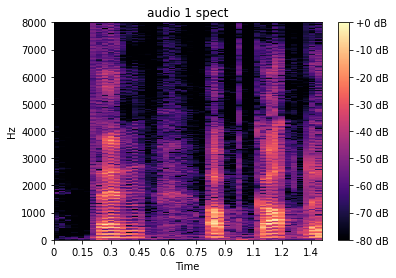

Spectrogram shape:  (512, 44)


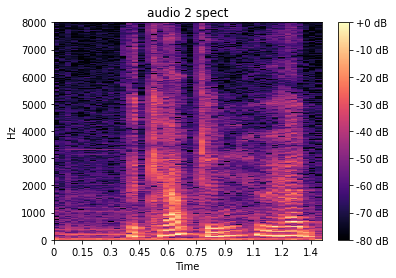

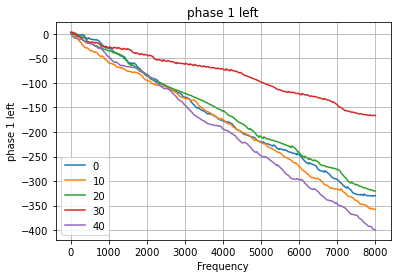

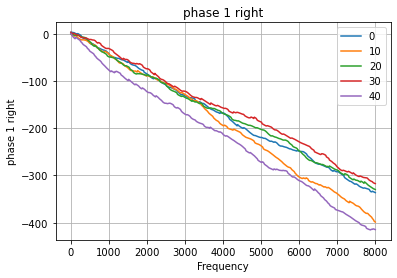

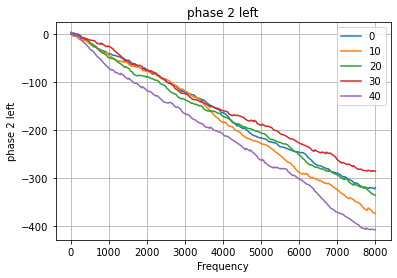

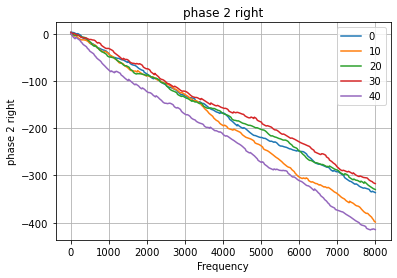

In [11]:
from math import pi
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
import pandas as pd
import soundfile as sf
from glob import glob
import librosa
from scipy import signal

from data_loader import *
from utils import *

class CuesShape:
    def __init__(
        self,
        Nfreq = 512,
        Ntime = 44,
        Ncues = 5,
        Nloc = 187,
        lenSliceInSec = 0.5,
        valSNRList = [-5,0,5,10,15,20,25,30,35]
    ):
        self.Nfreq = Nfreq
        self.Ntime = Ntime
        self.Ncues = Ncues
        self.Nloc = Nloc
        self.lenSliceInSec = lenSliceInSec
        self.valSNRList = valSNRList

speech_male = glob(os.path.join("./audio_train/speech_male/*"))
speech_female = glob(os.path.join("./audio_train/speech_female/*"))
audio_1, fs_audio_1 = sf.read(speech_male[0])
audio_2, fs_audio_2 = sf.read(speech_female[1])
sigSeqPower = 10*np.log10(np.mean(np.power(audio_1, 2)))
print(f"sigSeqPower: {sigSeqPower}")
raise SystemExit

hrirSet, locLabel, fs_HRIR = loadHRIR("./HRTF/IRC*")
# resampling the HRIR
temp = librosa.resample(hrirSet[0, 0], fs_HRIR, fs_audio_1)
hrirSet_re = np.empty(hrirSet.shape[0:2]+temp.shape)
for i in range(hrirSet.shape[0]):
    hrirSet_re[i, 0] = librosa.resample(hrirSet[i, 0], fs_HRIR, fs_audio_1)
    hrirSet_re[i, 1] = librosa.resample(hrirSet[i, 1], fs_HRIR, fs_audio_1)
print(hrirSet_re.shape)
del temp, hrirSet

audioSliceList_1 = audioSliceGenerator(audio_1, fs_HRIR, lenSliceInSec=0.5, threshold=0)
audioSliceList_2 = audioSliceGenerator(audio_2, fs_HRIR, lenSliceInSec=0.5, threshold=0)
print("how many slices: ", len(audioSliceList_1), len(audioSliceList_2))
sliceIndex_1 = 0
sliceIndex_2 = 0

slice_1 = audio_1[audioSliceList_1[sliceIndex_1]]
slice_2 = audio_2[audioSliceList_2[sliceIndex_2]]
locIndex_1 = 96
locIndex_2 = 107
print(len(audio_1))

sigLeft_1 = np.convolve(slice_1, hrirSet_re[locIndex_1, 0], 'same')
sigRight_1 = np.convolve(slice_1, hrirSet_re[locIndex_1, 1], 'same')
sigLeft_2 = np.convolve(slice_2, hrirSet_re[locIndex_2, 0], 'same')
sigRight_2 = np.convolve(slice_2, hrirSet_re[locIndex_2, 1], 'same')

cuesShape = CuesShape()
binaural_cues = BinauralCues(prep_method="minmax", fs_audio=fs_audio_1)
ipd, ild, magL, phaseL, magR, phaseR = binaural_cues(sigLeft_1+sigLeft_2, sigRight_1+sigRight_2)
ild = binaural_cues.calILD(binaural_cues.calSpectrogram(sigLeft_1+sigLeft_2), binaural_cues.calSpectrogram(sigRight_1+sigRight_2))
print("ild ", ild.shape)
print(binaural_cues.Nfreq, binaural_cues.Ntime)
# raise SystemExit("debug")

vis_cues = VisualiseCues(fs_audio=fs_audio_1, freq_axis=binaural_cues.freq_axis, time_axis=binaural_cues.time_axis)

vis_cues.showSpectrogram(binaural_cues.calSpectrogram(slice_1), figTitle="audio 1 spect", isLog=True)
vis_cues.showSpectrogram(binaural_cues.calSpectrogram(slice_2), figTitle="audio 2 spect", isLog=True)

# vis_cues.showCues(ipd, figTitle="ipd")
# vis_cues.showCues(ild, figTitle="ild")
# vis_cues.showCues(magL, figTitle="magL")
# vis_cues.showCues(phaseL, figTitle="phaseL")
# vis_cues.showCues(magR, figTitle="magR")
# vis_cues.showCues(phaseR, figTitle="phaseR")

f, t, Sxx_L = signal.spectrogram(sigLeft_1, fs_audio_1, nfft=1023, mode="phase")
f, t, Sxx_L = signal.spectrogram(sigRight_1, fs_audio_1, nfft=1023, mode="phase")
f, t, Sxx_R_2 = signal.spectrogram(sigLeft_2, fs_audio_2, nfft=1023, mode="phase")
f, t, Sxx_L_2 = signal.spectrogram(sigRight_2, fs_audio_1, nfft=1023, mode="phase")
vis_cues.showCues(Sxx_L, figTitle="phase 1 left")
vis_cues.showCues(Sxx_R, figTitle="phase 1 right")
vis_cues.showCues(Sxx_L_2, figTitle="phase 2 left")
vis_cues.showCues(Sxx_R_2, figTitle="phase 2 right")


./HRTF\IRC_1002
1
re.compile('IRC_\\d{4,4}')
[1002]
dict_keys(['__header__', '__version__', '__globals__', 'r_eq_hrir_S', 'l_eq_hrir_S'])
[('elev_v', 'O'), ('azim_v', 'O'), ('type_s', 'O'), ('sampling_hz', 'O'), ('content_m', 'O')]
locLabel shape:  (187, 2)  (order: elev, azim)
hrirSet shape:  (187, 2, 512)
(187, 2, 186)
how many slices:  3 9
78880
Preprocessing method: minmax
ild  (512, 44)
512 44
Spectrogram shape:  (512, 44)


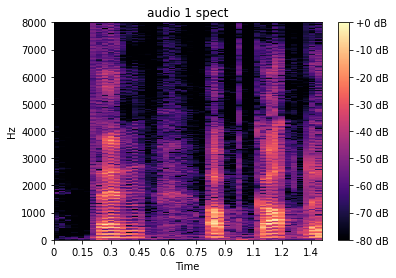

Spectrogram shape:  (512, 44)


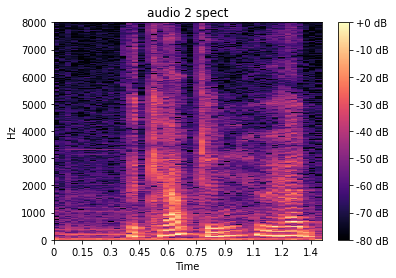

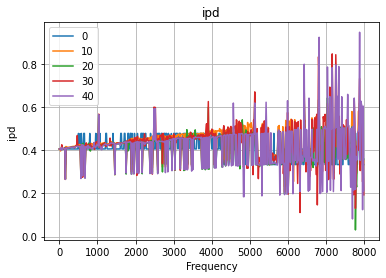

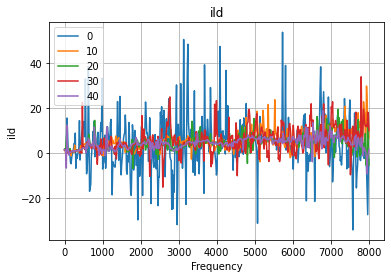

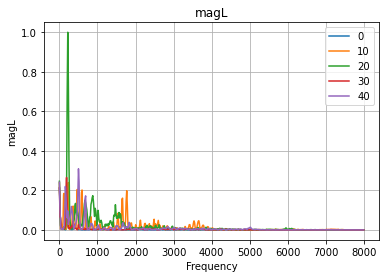

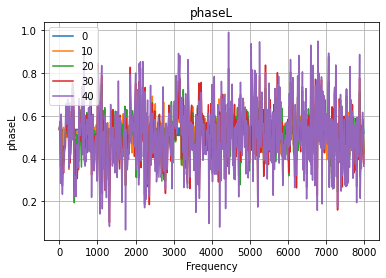

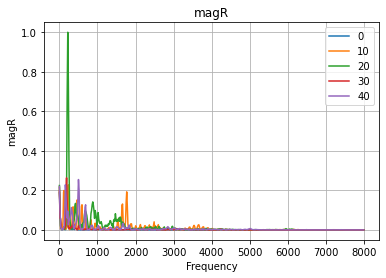

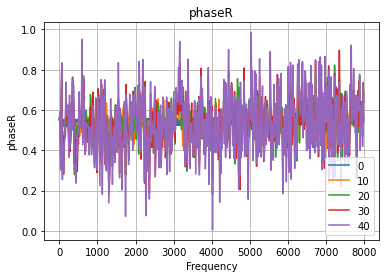

In [2]:
from math import pi
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
import pandas as pd
import soundfile as sf
from glob import glob
import librosa

from data_loader import *
from utils import *

class CuesShape:
    def __init__(
        self,
        Nfreq = 512,
        Ntime = 44,
        Ncues = 5,
        Nloc = 187,
        lenSliceInSec = 0.5,
        valSNRList = [-5,0,5,10,15,20,25,30,35]
    ):
        self.Nfreq = Nfreq
        self.Ntime = Ntime
        self.Ncues = Ncues
        self.Nloc = Nloc
        self.lenSliceInSec = lenSliceInSec
        self.valSNRList = valSNRList

speech_male = glob(os.path.join("./audio_train/speech_male/*"))
speech_female = glob(os.path.join("./audio_train/speech_female/*"))
audio_1, fs_audio_1 = sf.read(speech_male[0])
audio_2, fs_audio_2 = sf.read(speech_female[1])

hrirSet, locLabel, fs_HRIR = loadHRIR("./HRTF/IRC*")
# resampling the HRIR
temp = librosa.resample(hrirSet[0, 0], fs_HRIR, fs_audio_1)
hrirSet_re = np.empty(hrirSet.shape[0:2]+temp.shape)
for i in range(hrirSet.shape[0]):
    hrirSet_re[i, 0] = librosa.resample(hrirSet[i, 0], fs_HRIR, fs_audio_1)
    hrirSet_re[i, 1] = librosa.resample(hrirSet[i, 1], fs_HRIR, fs_audio_1)
print(hrirSet_re.shape)
del temp, hrirSet

audioSliceList_1 = audioSliceGenerator(audio_1, fs_HRIR, lenSliceInSec=0.5, threshold=0)
audioSliceList_2 = audioSliceGenerator(audio_2, fs_HRIR, lenSliceInSec=0.5, threshold=0)
print("how many slices: ", len(audioSliceList_1), len(audioSliceList_2))
locIndex_1 = 73
locIndex_2 = 145
print(len(audio_1))
sigLeft_1 = np.convolve(audio_1[:22050], hrirSet_re[locIndex_1, 0])
sigRight_1 = np.convolve(audio_1[:22050], hrirSet_re[locIndex_1, 1])
sigLeft_2 = np.convolve(audio_2[:22050], hrirSet_re[locIndex_2, 0])
sigRight_2 = np.convolve(audio_2[:22050], hrirSet_re[locIndex_2, 1])

cuesShape = CuesShape()
binaural_cues = BinauralCues(prep_method="minmax", fs_audio=fs_audio_1)
ipd, magL, phaseL, magR, phaseR = binaural_cues(sigLeft_1+sigLeft_2, sigRight_1+sigRight_2)
ild = binaural_cues.calILD(binaural_cues.calSpectrogram(sigLeft_1+sigLeft_2), binaural_cues.calSpectrogram(sigRight_1+sigRight_2))
print("ild ", ild.shape)
print(binaural_cues.Nfreq, binaural_cues.Ntime)
# raise SystemExit("debug")
vis_cues = VisualiseCues(fs_audio=fs_audio_1, freq_axis=binaural_cues.freq_axis, time_axis=binaural_cues.time_axis)

vis_cues.showSpectrogram(binaural_cues.calSpectrogram(audio_1[:22050]), figTitle="audio 1 spect", isLog=True)
vis_cues.showSpectrogram(binaural_cues.calSpectrogram(audio_2[:22050]), figTitle="audio 2 spect", isLog=True)
vis_cues.showCues(ipd, figTitle="ipd")
vis_cues.showCues(ild, figTitle="ild")
vis_cues.showCues(magL, figTitle="magL")
vis_cues.showCues(phaseL, figTitle="phaseL")
vis_cues.showCues(magR, figTitle="magR")
vis_cues.showCues(phaseR, figTitle="phaseR")


In [9]:
from math import pi
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
import pandas as pd
import soundfile as sf
from glob import glob
import librosa

from data_loader import *
from utils import *

class CuesShape:
    def __init__(
        self,
        Nfreq = 512,
        Ntime = 44,
        Ncues = 5,
        Nloc = 187,
        lenSliceInSec = 0.5,
        valSNRList = [-5,0,5,10,15,20,25,30,35]
    ):
        self.Nfreq = Nfreq
        self.Ntime = Ntime
        self.Ncues = Ncues
        self.Nloc = Nloc
        self.lenSliceInSec = lenSliceInSec
        self.valSNRList = valSNRList

speech_male = glob(os.path.join("./audio_train/speech_male/*"))
speech_female = glob(os.path.join("./audio_train/speech_male/*"))
audio_1, fs_audio_1 = sf.read(speech_male[1])
audio_2, fs_audio_2 = sf.read(speech_female[3])
power_1 = 10*np.log10(np.mean(np.power(audio_1, 2)))
power_2 = 10*np.log10(np.mean(np.power(audio_2, 2)))
print(power_1, power_2)
raise SystemExit("debug")

hrirSet, locLabel, fs_HRIR = loadHRIR("./HRTF/IRC*")
# resampling the HRIR
temp = librosa.resample(hrirSet[0, 0], fs_HRIR, fs_audio_1)
hrirSet_re = np.empty(hrirSet.shape[0:2]+temp.shape)
for i in range(hrirSet.shape[0]):
    hrirSet_re[i, 0] = librosa.resample(hrirSet[i, 0], fs_HRIR, fs_audio_1)
    hrirSet_re[i, 1] = librosa.resample(hrirSet[i, 1], fs_HRIR, fs_audio_1)
print(hrirSet_re.shape)
del temp, hrirSet

audioSliceList_1 = audioSliceGenerator(audio_1, fs_HRIR, lenSliceInSec=0.5, threshold=0)
audioSliceList_2 = audioSliceGenerator(audio_2, fs_HRIR, lenSliceInSec=0.5, threshold=0)
print("how many slices: ", len(audioSliceList_1), len(audioSliceList_2))
locIndex_1 = 73
locIndex_2 = 145
print(len(audio_1))
sigLeft_1 = np.convolve(audio_1[audioSliceList_1[1]], hrirSet_re[locIndex_1, 0])
sigRight_1 = np.convolve(audio_1[audioSliceList_1[1]], hrirSet_re[locIndex_1, 1])
sigLeft_2 = np.convolve(audio_2[:22050], hrirSet_re[locIndex_2, 0])
sigRight_2 = np.convolve(audio_2[:22050], hrirSet_re[locIndex_2, 1])

cuesShape = CuesShape()
binaural_cues = BinauralCues(prep_method="minmax", fs_audio=fs_audio_1)
ipd, magL, phaseL, magR, phaseR = binaural_cues(sigLeft_1+sigLeft_2, sigRight_1+sigRight_2)
ild = binaural_cues.calILD(binaural_cues.calSpectrogram(sigLeft_1+sigLeft_2), binaural_cues.calSpectrogram(sigRight_1+sigRight_2))
print("ild ", ild.shape)
print(binaural_cues.Nfreq, binaural_cues.Ntime)
# raise SystemExit("debug")
vis_cues = VisualiseCues(fs_audio=fs_audio_1, freq_axis=binaural_cues.freq_axis, time_axis=binaural_cues.time_axis)

vis_cues.showSpectrogram(binaural_cues.calSpectrogram(audio_1[audioSliceList_1[1]]), figTitle="audio 1 spect", isLog=False)
vis_cues.showSpectrogram(binaural_cues.calSpectrogram(audio_2[:22050]), figTitle="audio 2 spect", isLog=False)
vis_cues.showCues(ipd, figTitle="ipd")
vis_cues.showCues(ild, figTitle="ild")
vis_cues.showCues(magL, figTitle="magL")
vis_cues.showCues(phaseL, figTitle="phaseL")
vis_cues.showCues(magR, figTitle="magR")
vis_cues.showCues(phaseR, figTitle="phaseR")

-28.78765675323507 -29.405349298827904


SystemExit: debug

In [7]:
from glob import glob
import soundfile as sf
import numpy as np

speech_male = glob(os.path.join("./audio_train/music/*"))
speech_female = glob(os.path.join("./audio_train/speech_female/*"))
audio_1, fs_audio_1 = sf.read(speech_male[-1])
audio_2, fs_audio_2 = sf.read(speech_female[-1])
power_1 = 10*np.log10(np.mean(np.power(audio_1, 2)))
power_2 = 10*np.log10(np.mean(np.power(audio_2, 2)))
print(power_1, power_2)

-16.593241673846865 -23.379699432320443


In [8]:
target_power = -10

audio_1 *= np.power(10, (target_power - power_1)/20)
power_1 = 10*np.log10(np.mean(np.power(audio_1, 2)))
print(power_1)

-9.999999999999998


./audio_test/speech_female\19-198-0000.flac
-26.56595518145967


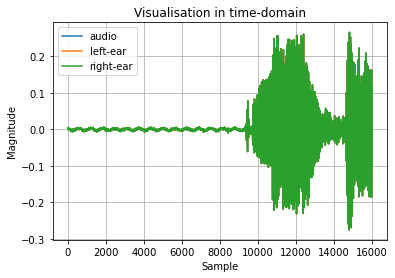

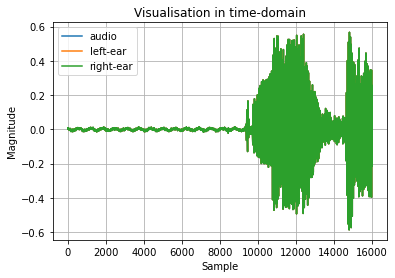

In [14]:
from utils import *
from glob import glob
import os

path = glob(os.path.join("./audio_test/speech_female/*"))
print(path[0])
audio_sig = AudioSignal(path=path[0], slice_duration=1)
audio = audio_sig(0)

vis_cues = VisualiseCues(fs_audio=audio_sig.fs_audio, freq_axis=np.linspace(0,8000,512), time_axis=np.linspace(0,1,72))
print(audio_sig.mean_power)
vis_cues.showBinauralSig(audio,audio,audio)
audio = audio_sig.apply_gain(audio, target_power=-20)
vis_cues.showBinauralSig(audio,audio,audio)

[1002]
./HRTF\IRC_1002\COMPENSATED/MAT/HRIR/IRC_1002_C_HRIR.mat
locLabel shape:  (187, 2)  (order: elev, azim)
HRIR shape after resampling: (187, 2, 186)
Preprocessing method: standardise
Number of locations in each region: 40, 44, 40, 44


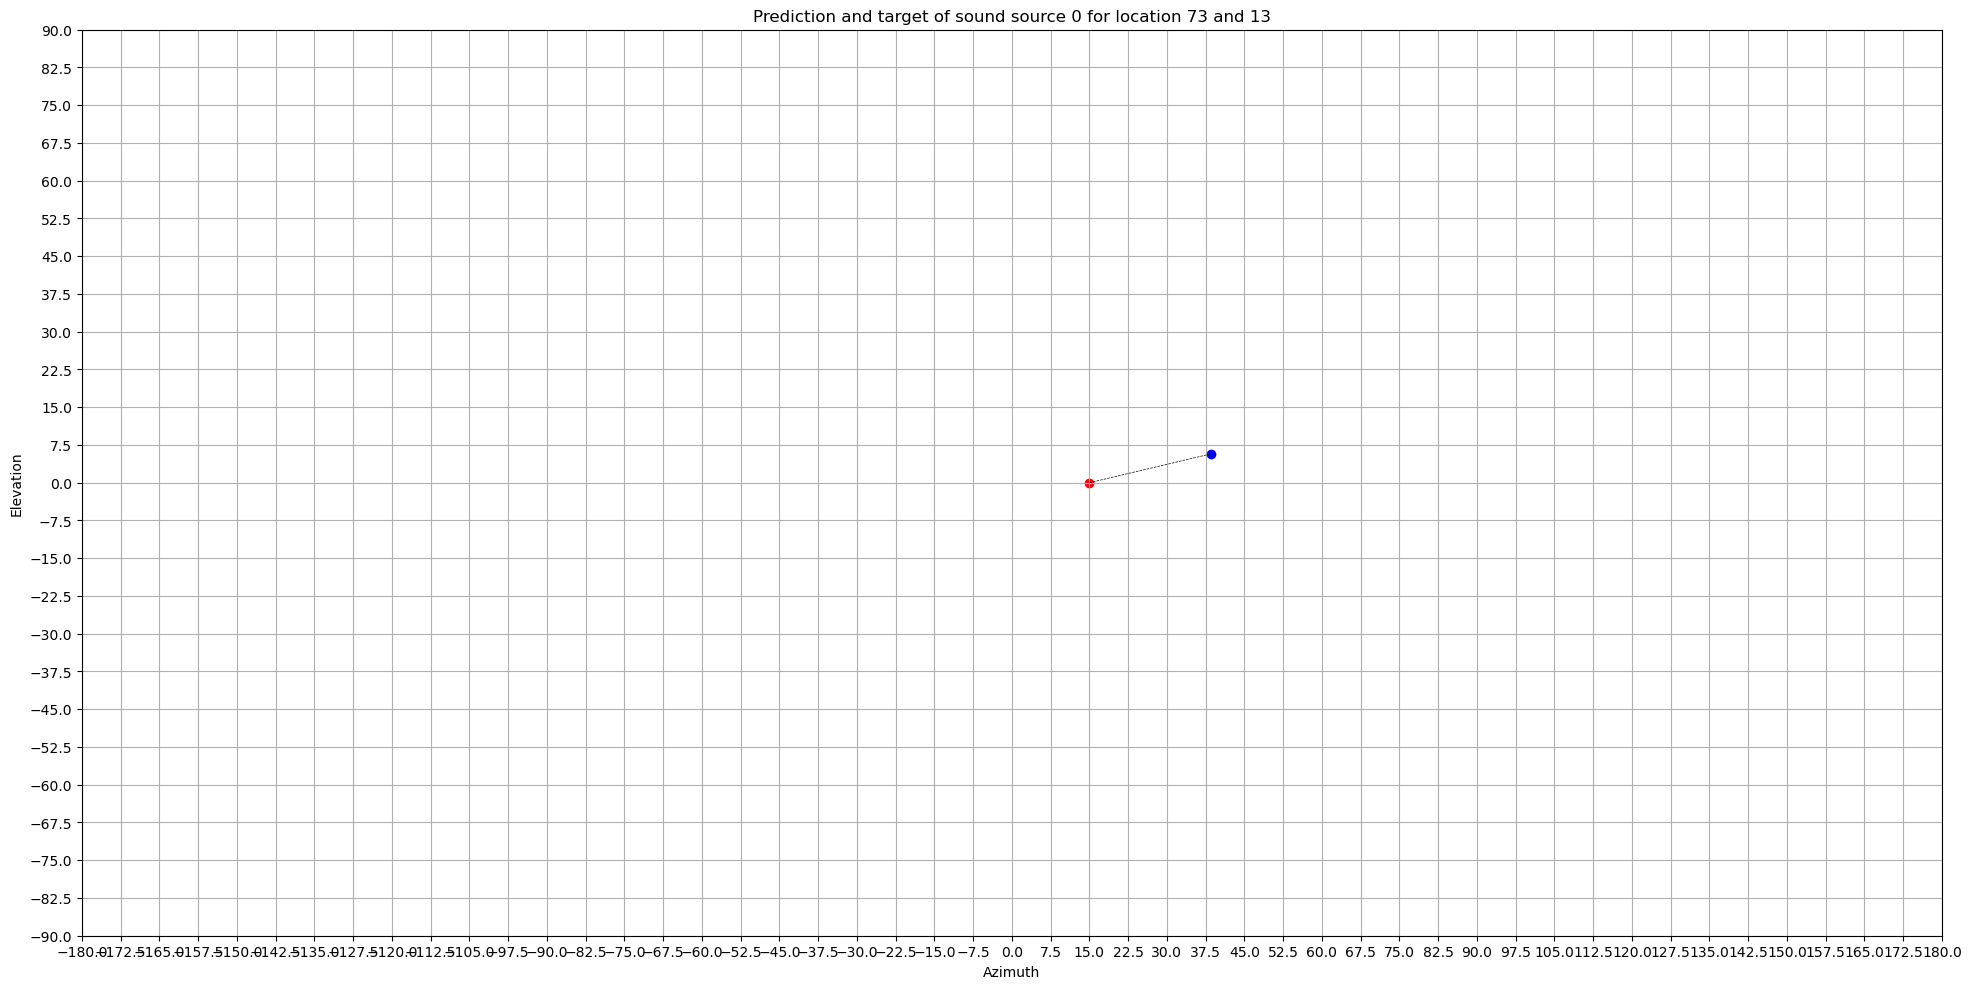

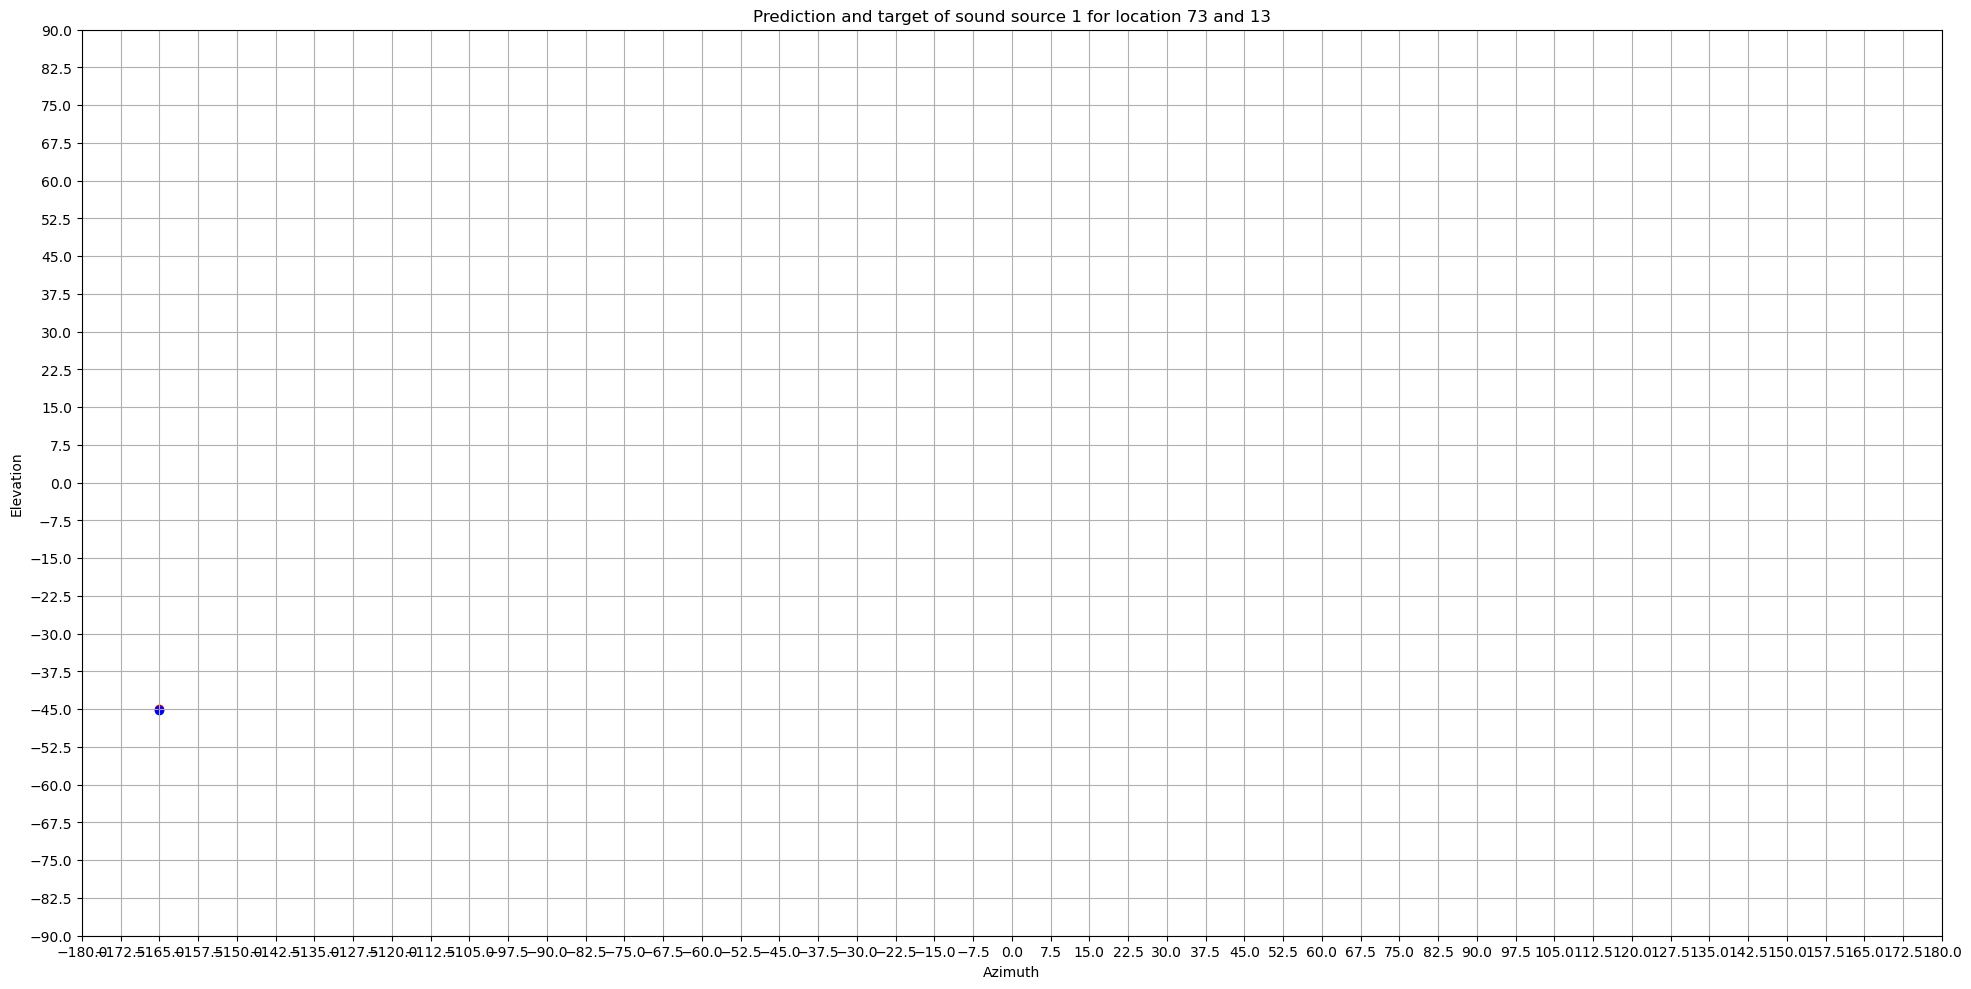

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
%run model_test_multiSound.py ./saved_0808_temp/ ./audio_test/speech_male/ ./audio_test/speech_female/ D:\SSSL-D\HPC\1008_2Sound_src/ "transformer" "src" --numEnc 3 --isHPC "T"

In [7]:
print(np.linspace(-180, 180, 25))

[-180. -165. -150. -135. -120. -105.  -90.  -75.  -60.  -45.  -30.  -15.
    0.   15.   30.   45.   60.   75.   90.  105.  120.  135.  150.  165.
  180.]


In [5]:
def cal(a):
    a += 1
    return a

a = 1
b = cal(a)
print(b)

2


In [1]:
import torch
import torch.nn as nn
from utils import *

# a = torch.tensor([0.1, 0.2, 0.3])
# b = torch.tensor([0.4, 0.6, 0.5])

a = torch.tensor(
    [[ 0.9330,  0.2500,  0.2588,  0.9330, -0.2500, -0.2588],
        [ 0.6830,  0.6830,  0.2588, -0.6830, -0.6830,  0.2588],
        [ 0.6830,  0.6830,  0.2588, -0.4330, -0.7500,  0.5000],
        [ 0.8365,  0.4830,  0.2588, -0.4830, -0.8365,  0.2588],
        [ 0.9330,  0.2500,  0.2588,  0.4330, -0.7500,  0.5000]]
)
batch_size, tensor_len = a.shape
elev = torch.empty(batch_size, int(tensor_len/3*2))
azim = torch.empty(batch_size, int(tensor_len/3*2))
for i in range(0,a.shape[-1],3):
    print(f"x: {a[:,i]}, x^2: {a[:,i] **2}")
    print(f"y: {a[:,i+1]}, y^2: {a[:,i+1] **2}")
    print(f"z: {a[:,i+2]}, z^2: {a[:,i+2] **2}")
    r = torch.sqrt(a[:,i] **2 + a[:,i+1] **2 + a[:,i+2] **2)
    print(f"r: {r}")
    elev[:,int(i/3)] = torch.arcsin(torch.div(a[:,i+2], r))
    azim[:,int(i/3)] = torch.arctan(torch.div(a[:,i+1], a[:,i]))
    print(f"elev: {radian2Degree(elev[:,int(i/3)])}, azim:{radian2Degree(azim[:,int(i/3)])}")

x: tensor([0.9330, 0.6830, 0.6830, 0.8365, 0.9330]), x^2: tensor([0.8705, 0.4665, 0.4665, 0.6997, 0.8705])
y: tensor([0.2500, 0.6830, 0.6830, 0.4830, 0.2500]), y^2: tensor([0.0625, 0.4665, 0.4665, 0.2333, 0.0625])
z: tensor([0.2588, 0.2588, 0.2588, 0.2588, 0.2588]), z^2: tensor([0.0670, 0.0670, 0.0670, 0.0670, 0.0670])
r: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
elev: tensor([14.9991, 14.9992, 14.9992, 14.9989, 14.9991]), azim:tensor([15.0002, 45.0000, 45.0000, 30.0024, 15.0002])
x: tensor([ 0.9330, -0.6830, -0.4330, -0.4830,  0.4330]), x^2: tensor([0.8705, 0.4665, 0.1875, 0.2333, 0.1875])
y: tensor([-0.2500, -0.6830, -0.7500, -0.8365, -0.7500]), y^2: tensor([0.0625, 0.4665, 0.5625, 0.6997, 0.5625])
z: tensor([-0.2588,  0.2588,  0.5000,  0.2588,  0.5000]), z^2: tensor([0.0670, 0.0670, 0.2500, 0.0670, 0.2500])
r: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
elev: tensor([-14.9991,  14.9992,  30.0002,  14.9989,  30.0002]), azim:tensor([-15.0002,  45.0000,  60.0007,  59.9976, 

In [6]:
from utils import *

path = "./HRTF/IRC*"
hrirSet, locLabel, fs_HRIR = loadHRIR(path)

for i in range(187):
    # print("original label", locLabel[i])
    temp = spherical2Cartesian(locLabel[i])
    # print("convert to radian", temp)

    temp = radian2Degree(cartesian2Spherical(torch.from_numpy(np.expand_dims(temp, axis=0))))
    # print("converted back", temp.numpy())
    print("error of i=",i, locLabel[i]-temp.numpy())

[1002]
locLabel shape:  (187, 2)  (order: elev, azim)
error of i= 0 [[0. 0.]]
error of i= 1 [[0. 0.]]
error of i= 2 [[0. 0.]]
error of i= 3 [[0. 0.]]
error of i= 4 [[0. 0.]]
error of i= 5 [[0. 0.]]
error of i= 6 [[0. 0.]]
error of i= 7 [[0. 0.]]
error of i= 8 [[0. 0.]]
error of i= 9 [[0. 0.]]
error of i= 10 [[0. 0.]]
error of i= 11 [[0. 0.]]
error of i= 12 [[0. 0.]]
error of i= 13 [[0. 0.]]
error of i= 14 [[0. 0.]]
error of i= 15 [[0. 0.]]
error of i= 16 [[0. 0.]]
error of i= 17 [[0. 0.]]
error of i= 18 [[0. 0.]]
error of i= 19 [[0. 0.]]
error of i= 20 [[0. 0.]]
error of i= 21 [[0.00000000e+00 3.05175781e-05]]
error of i= 22 [[0. 0.]]
error of i= 23 [[0. 0.]]
error of i= 24 [[0. 0.]]
error of i= 25 [[0. 0.]]
error of i= 26 [[0. 0.]]
error of i= 27 [[0. 0.]]
error of i= 28 [[0. 0.]]
error of i= 29 [[0. 0.]]
error of i= 30 [[0. 0.]]
error of i= 31 [[0. 0.]]
error of i= 32 [[0. 0.]]
error of i= 33 [[0. 0.]]
error of i= 34 [[0. 0.]]
error of i= 35 [[0. 0.]]
error of i= 36 [[0. 0.]]
error o

In [33]:
import pickle

with open("./error_azim_2.pkl", "rb") as tf:
    error_elev_1 = pickle.load(tf)

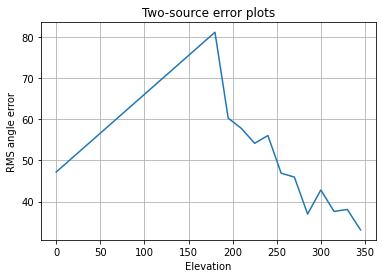

In [34]:
import collections

x_axis = []
y_axis_elev_1 = []
od_elev_1 = collections.OrderedDict(sorted(error_elev_1.items()))
for idx in od_elev_1:
    x_axis.append(idx)
    y_axis_elev_1.append(np.mean(error_elev_1[idx]))
plt.plot(x_axis, y_axis_elev_1)
plt.xlabel("Elevation")
plt.ylabel("RMS angle error")
plt.title("Two-source error plots")
plt.grid()
plt.show()